# Extraction + Learning : Hardware Spec Sheets

This notebook demonstrates the full entity extraction process on transistor data sheets, extracting min storage temperatures.

In [ ]:
%load_ext autoreload
%autoreload 2

### Extraction

In [45]:
from snorkel.parser import HTMLParser
html_parser = HTMLParser(path='data/hardware/hardware_docs/')

In [46]:
from snorkel.parser import TableParser
table_parser = TableParser()

In [ ]:
from snorkel.parser import CorpusParser
cp = CorpusParser(html_parser, table_parser, max_docs=10)
%time corpus = cp.parse_corpus(name='Hardware Corpus')

> /Users/bradenhancock/snorkel/snorkel/parser.py(201)get_nlp_tags()
-> if content.startswith("Request is too long") or content.startswith("CoreNLP request timed out"):
(Pdb) content
'{"sentences":[{"index":0,"parse":"SENTENCE_SKIPPED_OR_UNPARSABLE","basic-dependencies":[{"dep":"ROOT","governor":0,"governorGloss":"ROOT","dependent":1,"dependentGloss":"Rating"},{"dep":"punct","governor":1,"governorGloss":"Rating","dependent":2,"dependentGloss":"."}],"collapsed-dependencies":[{"dep":"ROOT","governor":0,"governorGloss":"ROOT","dependent":1,"dependentGloss":"Rating"},{"dep":"punct","governor":1,"governorGloss":"Rating","dependent":2,"dependentGloss":"."}],"collapsed-ccprocessed-dependencies":[{"dep":"ROOT","governor":0,"governorGloss":"ROOT","dependent":1,"dependentGloss":"Rating"},{"dep":"punct","governor":1,"governorGloss":"Rating","dependent":2,"dependentGloss":"."}],"tokens":[{"index":1,"word":"Rating","originalText":"Rating","lemma":"Rating","characterOffsetBegin":0,"characterOffsetEnd

BdbQuit: 

In [43]:
from snorkel.candidates import TableNgrams
from snorkel.matchers import NumberMatcher, RangeMatcher

# Define a candidate space
ngrams = TableNgrams(n_max=3)

# Define a matcher
number_matcher = RangeMatcher(low=-80,high=-40)

In [44]:
# from snorkel.candidates import Candidates
# %time candidates = Candidates(ngrams, number_matcher, corpus.get_contexts())
# for c in candidates.get_candidates()[:5]: print c
    
from snorkel.candidates import CandidateExtractor
ce = CandidateExtractor(ngrams, number_matcher)
%time candidates = ce.extract(corpus.get_tables(), name='all')
for cand in candidates[:10]: print cand

CPU times: user 16.9 s, sys: 470 ms, total: 17.4 s
Wall time: 17.4 s
Ngram("-40", context=None, chars=[0,2], words=[0,0])
Ngram("-40", context=None, chars=[0,2], words=[0,0])
Ngram("-55", context=None, chars=[0,2], words=[0,0])
Ngram("-40", context=None, chars=[0,2], words=[0,0])
Ngram("-40", context=None, chars=[0,2], words=[0,0])
Ngram("-50", context=None, chars=[0,2], words=[0,0])
Ngram("-50", context=None, chars=[0,2], words=[0,0])
Ngram("-50", context=None, chars=[4,6], words=[2,2])
Ngram("-50", context=None, chars=[4,6], words=[2,2])
Ngram("-50", context=None, chars=[4,6], words=[2,2])


### Learning

First, generate gold data.

In [7]:
# read from csv
import csv
with open('data/hardware/gold_all.csv', 'rb') as csvfile:
    gold_reader = csv.reader(csvfile)
    gold = []
    for row in gold_reader:
        (doc, part, temp, label) = row
        if label=='stg_temp_min':
            gold.append((doc,temp))
gold = set(gold)
print "%s gold annotations" % len(gold)

# match with candidates
gt_dict = {}
for c in candidates:
    filename = (c.context.document.file).split('.')[0]
    temp = c.get_attrib_span('words')
    label = 1 if (filename, temp) in gold else -1
    gt_dict[c.id] = label
print "%s out of %s candidates are positive" % (gt_dict.values().count(1), len(gt_dict))

98 gold annotations
0 out of 1 candidates are positive


Then confirm that features work:

In [8]:
from snorkel.features import TableNgramFeaturizer
featurizer = TableNgramFeaturizer()
featurizer.fit_transform(candidates)
for f in featurizer.get_features_by_candidate(candidates[0])[:10]: print f

DDLIB_WORD_SEQ_[-40]
DDLIB_LEMMA_SEQ_[-40]
DDLIB_POS_SEQ_[CD]
DDLIB_DEP_SEQ_[ROOT]
DDLIB_W_LEFT_1_[_NUMBER]
DDLIB_W_LEFT_POS_1_[CD]
DDLIB_LENGTH_1
TABLE_ROW_NUM_9
TABLE_COL_NUM_2
TABLE_HTML_TAG_td


We now build a legacy DDLiteModel with which we will do learning.

In [9]:
from snorkel.snorkel import DDLiteModel
DDL = DDLiteModel(candidates, featurizer.fit_transform(candidates), gt_dict)

DDL.set_holdout(idxs=range(50), validation_frac=0.5)
print "%s training data" % len(DDL.gt.get_labeled_ground_truth('training')[0])
print "%s test data" % len(DDL.gt.get_labeled_ground_truth('test')[0])
print "%s validation data" % len(DDL.gt.get_labeled_ground_truth('validation')[0])

75 training data
25 test data
25 validation data


Define labeling functions:

In [10]:
def LF_to(m):
    return 1 if 'to' in m.post_window('words') else 0
def LF_storage(m):
    return 1 if 'storage' in m.aligned('words') else -1
def LF_tstg(m):
    return 1 if 'tstg' in m.aligned('words') else -1
def LF_temperature(m):
    return 1 if 'temperature' in m.aligned('words') else -1

In [11]:
LFs = [LF_to, LF_storage, LF_tstg, LF_temperature]
DDL.apply_lfs(LFs, clear=True)

In [12]:
print DDL.lf_names
DDL.print_lf_stats()

['LF_to', 'LF_storage', 'LF_tstg', 'LF_temperature']
LF stats on training set
Coverage:	100.000%
Overlap:	100.000%
Conflict:	16.000%


In [13]:
DDL.top_conflict_lfs(n=3)

OrderedDict([('LF_storage', ['16.00%']),
             ('LF_temperature', ['16.00%']),
             ('LF_tstg', ['16.00%']),
             ('LF_to', ['0.00%'])])

In [14]:
DDL.lowest_coverage_lfs(n=3)

OrderedDict([('LF_storage', ['100.00%']),
             ('LF_temperature', ['100.00%']),
             ('LF_tstg', ['100.00%']),
             ('LF_to', ['33.33%'])])

Now learn, baby, learn!

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.716622
	Learning epoch = 250	Gradient mag. = 1.375269
Final gradient magnitude for rate=0.01, mu=1e-07: 1.977
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.676007
	Learning epoch = 250	Gradient mag. = 0.694459
	Learning epoch = 500	Gradient mag. = 0.677809
	Learning epoch = 750	Gradient mag. = 0.661628
	Learning epoch = 1000	Gradient mag. = 0.645900
	Learning epoch = 1250	Gradient mag. = 0.630611
	Learning epoch = 1500	Gradient mag. = 0.615747
	Learning epoch = 1750	Gradient mag. = 0.601294
	Learning epoch = 2000	Gradient mag. = 0.587239
	Learning epoch = 2250	Gradient mag. = 0.573570
	Learning epoch = 2500	Gradient mag. = 0.560275
	Learning epoch = 2750	Gradient mag. = 0.547344
Final gradient magnitude for rate=0.01, mu=1e-09: 0.535
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.676007
	Learning epoch = 250	Gradient mag. = 0

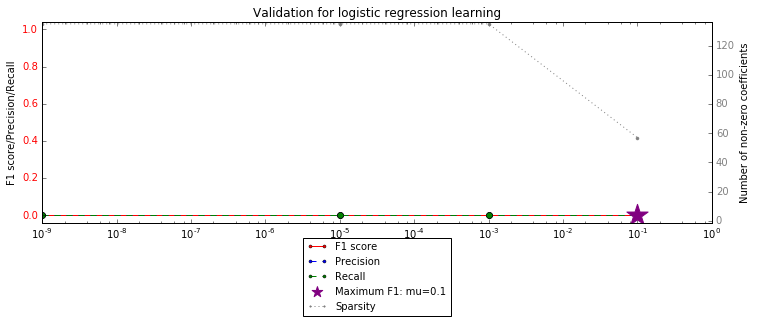

CPU times: user 3.34 s, sys: 57.9 ms, total: 3.4 s
Wall time: 3.45 s


<snorkel.snorkel.ModelLog instance at 0x150a44f38>

In [15]:
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

In [16]:
DDL.show_log()
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
print "Full model accuracy: {:.3f}".format(acc_feats)

Full model accuracy: 0.900


Tune in next time for relation extraction!